# <center> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


In [1]:
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
%pylab inline
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

Populating the interactive namespace from numpy and matplotlib


## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [2]:
with open('capstone_user_identification/X_sparse_10users.pkl', 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open('capstone_user_identification/y_10users.pkl', 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 13 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [3]:
X_sparse_10users.shape

(13279, 4914)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=7, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=7 – для воспроизводимости.**

In [5]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [6]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите KNeighborsClassifier со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только n_jobs=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект StratifiedKFold skf) по выборке (X_train, y_train) и отдельно на выборке (X_valid, y_valid).**

In [7]:
from sklearn.neighbors import KNeighborsClassifier

In [8]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

In [9]:
%%time
knn_cv_scores = cross_val_score(knn, X_train, y_train, cv=skf, n_jobs=-1)

Wall time: 5.48 s


In [21]:
knn_cv_scores.mean(), knn_cv_scores.std()

(0.53123051143725408, 0.0010331440593672654)

In [10]:
# обучение
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=100, p=2,
           weights='uniform')

In [14]:
%%time
# валидация
knn_valid_acc = accuracy_score(y_valid, knn.predict(X_valid))
print(knn_valid_acc)

0.570030120482
Wall time: 7.69 s


**2. Обучите случайный лес (RandomForestClassifier) из 100 деревьев (для воспроизводимости random_state=7). Посмотрите на OOB-оценку (для этого надо сразу установить oob_score=True) и на долю правильных ответов на выборке (X_valid, y_valid). Для распараллеливания задайте n_jobs=-1.**

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
forest = RandomForestClassifier(n_estimators=100, random_state=7, oob_score=True)

In [19]:
%%time
# обучение
forest.fit(X_train, y_train)

Wall time: 1min 30s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=7,
            verbose=0, warm_start=False)

In [20]:
# out of bag
forest.oob_score_

0.70876815492200107

In [21]:
# валидация
rf_valid_acc = accuracy_score(y_valid, forest.predict(X_valid))
print(rf_valid_acc)

0.72640562249


**3. Обучите логистическую регрессию (LogisticRegression) с параметром C по умолчанию и random_state=7 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект skf, созданный ранее) и на выборке (X_valid, y_valid). Для распараллеливания задайте n_jobs=-1.**

In [49]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [50]:
log_reg = LogisticRegression(random_state=7)

In [51]:
%%time
log_reg_cv_scores = cross_val_score(log_reg, X_train, y_train, cv=skf, n_jobs=-1)
print (log_reg_cv_scores.mean())

0.758046203678
Wall time: 5.52 s


In [52]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=7, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
#валидация
accuracy_score(y_valid, log_reg.predict(X_valid))

0.7743473895582329

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации C (быстрее, чем с GridSearchCV).**

**С помощью LogisticRegressionCV подберите параметр C для LogisticRegression сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте linspace из NumPy. Укажите у LogisticRegressionCV параметры multi_class='multinomial' и random_state=7. Для кросс-валидации используйте объект skf, созданный ранее. Для распараллеливания задайте n_jobs=-1.**

**Нарисуйте кривые валидации по параметру С.**

In [54]:
%%time
log_reg_c_values1 = np.linspace(1e-4, 1e4, 10)
log_reg_grid_searcher1 = LogisticRegressionCV(Cs=log_reg_c_values1, cv=skf, multi_class='multinomial', random_state=7, n_jobs=-1)
log_reg_grid_searcher1.fit(X_train, y_train)

Wall time: 33.4 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров С.

In [55]:
log_reg_mean_cv_scores1 = lg_grid_searcher1.scores_[31].mean(axis=0)

In [56]:
log_reg_grid_searcher1.Cs_

array([  1.00000000e-04,   1.11111120e+03,   2.22222230e+03,
         3.33333340e+03,   4.44444450e+03,   5.55555560e+03,
         6.66666670e+03,   7.77777780e+03,   8.88888890e+03,
         1.00000000e+04])

In [57]:
log_reg_mean_cv_scores1

array([ 0.29672472,  0.74588709,  0.74330675,  0.73975683,  0.73706599,
        0.73469904,  0.73276251,  0.73104066,  0.72974975,  0.72802807])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [58]:
print(log_reg_mean_cv_scores1.max(), log_reg_grid_searcher1.Cs_[log_reg_mean_cv_scores1.argmax()])

0.745887085666 1111.1112


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

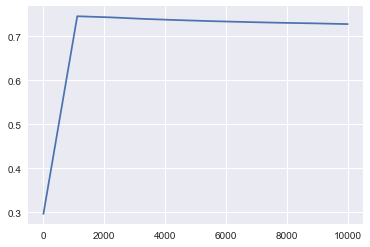

In [59]:
plot(log_reg_c_values1, log_reg_mean_cv_scores1);

**Теперь то же самое, только значения параметра C перебирайте в диапазоне np.linspace(1e-3, 1, 30). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [60]:
%%time
log_reg_c_values2 = np.linspace(1e-3, 1, 30)
log_reg_grid_searcher2 = LogisticRegressionCV(Cs=log_reg_c_values2, cv=skf, random_state=7, n_jobs=-1, multi_class='multinomial')
log_reg_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 14s


In [61]:
lg_c_values2

array([ 0.001     ,  0.03544828,  0.06989655,  0.10434483,  0.1387931 ,
        0.17324138,  0.20768966,  0.24213793,  0.27658621,  0.31103448,
        0.34548276,  0.37993103,  0.41437931,  0.44882759,  0.48327586,
        0.51772414,  0.55217241,  0.58662069,  0.62106897,  0.65551724,
        0.68996552,  0.72441379,  0.75886207,  0.79331034,  0.82775862,
        0.8622069 ,  0.89665517,  0.93110345,  0.96555172,  1.        ])

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров С.

In [64]:
log_reg_mean_cv_scores2 = log_reg_grid_searcher2.scores_[31].mean(axis=0)

In [65]:
log_reg_mean_cv_scores2

array([ 0.49015249,  0.6945673 ,  0.71823569,  0.7273811 ,  0.73308291,
        0.73727938,  0.74007758,  0.74330588,  0.7448122 ,  0.74631844,
        0.74804023,  0.74836274,  0.74857828,  0.74922323,  0.74943888,
        0.74976146,  0.75051408,  0.7509446 ,  0.75148269,  0.75223597,
        0.75255837,  0.7527736 ,  0.75223531,  0.75277336,  0.75363375,
        0.75384859,  0.75427894,  0.75427891,  0.75460142,  0.75417145])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [68]:
print(log_reg_mean_cv_scores2.max(), log_reg_grid_searcher2.Cs_[log_reg_mean_cv_scores2.argmax()])

0.754601419039 0.965551724138


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

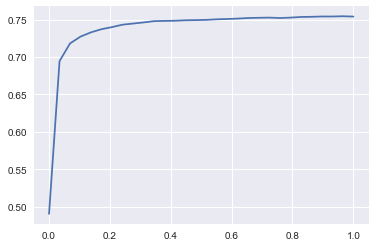

In [69]:
plot(log_reg_c_values2, log_reg_mean_cv_scores2);

Выведите долю правильных ответов на выборке (X_valid, y_valid) для логистической регрессии с лучшим найденным значением C.

In [70]:
log_reg_cv_accuracy = accuracy_score(y_valid, log_reg_grid_searcher2.predict(X_valid))

In [71]:
log_reg_cv_accuracy

0.77409638554216864

**4. Обучите линейный SVM (LinearSVC) с параметром C=1 и random_state=7 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект skf, созданный ранее) и на выборке (X_valid, y_valid).**

In [72]:
from sklearn.svm import LinearSVC

In [73]:
svm = LinearSVC(C=1, random_state=7)

In [75]:
%%time
svm_cv_scores = cross_val_score(svm, X_train, y_train, cv=skf, n_jobs=-1)
print (svm_cv_scores.mean())

0.748038040809
Wall time: 9.7 s


In [76]:
%%time
svm.fit(X_train, y_train)

Wall time: 8.62 s


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=7, tol=0.0001,
     verbose=0)

In [77]:
accuracy_score(y_valid, svm.predict(X_valid))

0.76506024096385539

**С помощью GridSearchCV подберите параметр C для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте linspace из NumPy. Нарисуйте кривые валидации.**

In [78]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, cv=skf, n_jobs=-1)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 56 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [79]:
print(svm_grid_searcher1.best_score_, svm_grid_searcher1.best_params_)

0.68187197418 {'C': 8888.8888999999999}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

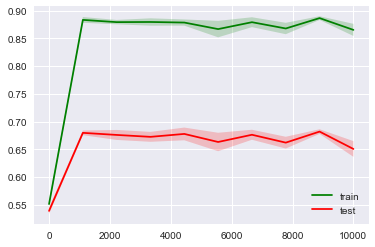

In [80]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений C). Здесь намного осмысленней подбирать C в районе 1, к тому же, так модель быстрее обучается, чем при больших C. **

**С помощью GridSearchCV подберите параметр C для SVM в диапазоне (1e-3, 1), 30 значений, используйте linspace из NumPy. Нарисуйте кривые валидации.**

In [81]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, cv=skf, n_jobs=-1)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 25s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [82]:
print(svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_)

0.761699838623 {'C': 0.17324137931034483}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

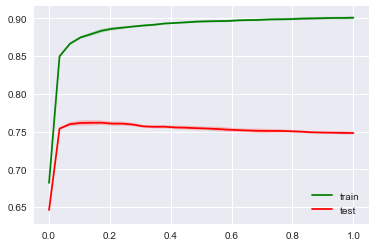

In [83]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке (X_valid, y_valid) для LinearSVC с лучшим найденным значением C.

In [86]:
print(accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid)))

0.776857429719


## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем LinearSVC, показавший лучшее качество на кросс-валидации в 1 части и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации C.**

**Определите функцию model_assessment, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с train_test_split должно быть стратифицированным. Не теряйте нигде random_state.**

In [84]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, 
                     random_state=7, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    t_start = time()
    # Loading data
    with open(path_to_X_pickle, 'rb') as fid:
        X_sparse = pickle.load(fid)
    with open(path_to_y_pickle, 'rb') as fid:
        y = pickle.load(fid)
    #print(X_sparse.shape)
    # Spliting on train and validation
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                                                          test_size=test_size, 
                                                          random_state=random_state,
                                                          stratify=y)
    
    # Cross_validation extimation
    scores = cross_val_score(estimator, X_train, y_train, cv=cv, n_jobs=-1)
    # Model fitting
    estimator.fit(X_train, y_train)
    # Accuracy score on validation set
    acc_score = accuracy_score(y_valid, estimator.predict(X_valid))
    
    return scores.mean(), acc_score, time() - t_start

**Убедитесь, что функция работает.**

In [85]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 'capstone_user_identification/X_sparse_10users.pkl',
                 'capstone_user_identification/y_10users.pkl', skf, random_state=7, test_size=0.3)

(0.76170225920001722, 0.7768574297188755, 9.160332202911377)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, svm\_grid\_searcher2.best\_estimator\_) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем скромном маке этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

In [88]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length and (window_size, session_length) != (10, 10):
        path_to_X_pkl = 'capstone_user_identification/X_sparse_10users_s' + \
                        str(session_length) + '_w' + str(window_size) + '.pkl'
        path_to_y_pkl = 'capstone_user_identification/y_10users_s' + \
                        str(session_length) + '_w' + str(window_size) + '.pkl'
        print("Session length: {}, Window size: {}".format(session_length, window_size))
        print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=7, test_size=0.3))

Session length: 15, Window size: 10
(0.8261820838640247, 0.8321934538348803, 18.725696325302124)
Session length: 15, Window size: 7
(0.84541720785789842, 0.86361296963458567, 18.582615613937378)
Session length: 10, Window size: 7
(0.78600824439944528, 0.8137393767705382, 9.89859914779663)
Session length: 7, Window size: 7
(0.734671855980911, 0.75620518477661336, 7.300518035888672)
Session length: 15, Window size: 5
(0.866699991019518, 0.87938461538461543, 23.59575319290161)
Session length: 10, Window size: 5
(0.8145056225811621, 0.8294731483838127, 15.41455340385437)
Session length: 7, Window size: 5
(0.76452606616112406, 0.7844200502579024, 10.066450357437134)
Session length: 5, Window size: 5
(0.70653074906085367, 0.71304833752444818, 8.2646164894104)
Wall time: 1min 51s


In [89]:
cv_score, accur_score, _ = model_assessment(svm_grid_searcher2.best_estimator_, 
                                     'capstone_user_identification/X_sparse_10users_s15_w5.pkl',
                                     'capstone_user_identification/y_10users_s15_w5.pkl', skf, random_state=7, test_size=0.3)

In [90]:
print(cv_score, accur_score)

0.86669999102 0.879384615385


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 10 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [92]:
with open('capstone_user_identification/X_sparse_150users.pkl', 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open('capstone_user_identification/y_150users.pkl', 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [93]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                                      random_state=7, stratify=y_150users)

**Обучите LogisticRegressionCV для одного значения параметра C (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент multi_class='ovr'. Как всегда, где возможно, указывайте n_jobs=-1 и random_state=7.**

In [95]:
C_opt = log_reg_grid_searcher2.Cs_[log_reg_mean_cv_scores2.argmax()]
C_opt2 = log_reg_grid_searcher2.Cs_[log_reg_mean_cv_scores2.argmax()]
C_opt

0.965551724137931

In [96]:
%%time
log_reg_cv_150users = LogisticRegressionCV(Cs=[C_opt], cv=skf, random_state=7, n_jobs=-1, multi_class='ovr')
log_reg_cv_150users.fit(X_train_150, y_train_150)

Wall time: 10min 33s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [97]:
cv_scores_by_user = log_reg_cv_150users.scores_
for user_id in log_reg_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, cv_scores_by_user[user_id].mean()))

User 6, CV score: 0.9960484786573494
User 13, CV score: 0.9962751514546545
User 15, CV score: 0.9949471653934209
User 16, CV score: 0.9920437096857837
User 28, CV score: 0.9899266006347945
User 31, CV score: 0.9944075141010331
User 33, CV score: 0.9935977275769495
User 39, CV score: 0.9869365887397334
User 46, CV score: 0.997905595756198
User 49, CV score: 0.9947741963375232
User 50, CV score: 0.9944829626516594
User 53, CV score: 0.9935115797290349
User 65, CV score: 0.9968042646304868
User 66, CV score: 0.9946989394825464
User 82, CV score: 0.9962645119797672
User 85, CV score: 0.9960916008684917
User 89, CV score: 0.9904345318599098
User 92, CV score: 0.994752881664183
User 100, CV score: 0.9950338287515414
User 102, CV score: 0.9910929049231599
User 103, CV score: 0.9799725095731012
User 105, CV score: 0.9966206725083931
User 106, CV score: 0.9944933173664258
User 118, CV score: 0.9906503030679509
User 119, CV score: 0.9966312077187661
User 120, CV score: 0.9940190417638363
User 12

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью LogisticRegressionCV) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [100]:
class_distr = np.bincount(y_train_150.astype('int'))
np.bincount(y_train_150.astype('int')).shape

(2903,)

In [101]:
# для примера
(class_distr.sum() - class_distr[6])/class_distr.sum()

0.9870228018656072

In [102]:
class_distr[128]

1708

In [103]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = []
for user_id in np.unique(y_train_150):
    val = (class_distr.sum() - class_distr[user_id])/class_distr.sum()
    print(val)
    acc_diff_vs_constant.append(cv_scores_by_user[user_id].mean() - val)
    print("User: {} difference: {}".format(user_id, cv_scores_by_user[user_id].mean() -\
                                           val))

0.987022801866
User: 6 difference: 0.009025676791742154
0.99556270513
User: 13 difference: 0.0007124463242347279
0.994267144585
User: 15 difference: 0.0006800208088639792
0.984258939368
User: 16 difference: 0.007784770318017276
0.987616600449
User: 28 difference: 0.0023100001856668495
0.994299533598
User: 31 difference: 0.00010798050282967431
0.992410174469
User: 33 difference: 0.0011875531081293467
0.984906719641
User: 39 difference: 0.002029869099035575
0.997020210745
User: 46 difference: 0.0008853850116825601
0.993684142339
User: 49 difference: 0.0010900539986045121
0.994321126274
User: 50 difference: 0.0001618363776915155
0.991902746588
User: 53 difference: 0.0016088331406777234
0.996815080325
User: 65 difference: -1.0815694267085618e-05
0.994688201762
User: 66 difference: 1.0737720584019783e-05
0.996232078079
User: 82 difference: 3.243390065166274e-05
0.996059336673
User: 85 difference: 3.226419549118287e-05
0.989819053377
User: 89 difference: 0.0006154784828152904
0.99449386768
U

In [104]:
better_than_default = (np.array(acc_diff_vs_constant) > 0).sum()
better_than_default

133

In [107]:
better_than_default/len(acc_diff_vs_constant)

0.88666666666666671

**Дальше будем строить кривые обучения для конткретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [108]:
y_binary_128 = y_150users == 128
y_binary_128.astype('int')

array([0, 0, 0, ..., 0, 0, 0])

In [109]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [110]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, 
                                              X_sparse_150users, y_binary_128, 
                                              train_sizes=train_sizes, 
                                              cv=skf, 
                                              n_jobs=-1)

Wall time: 39.7 s


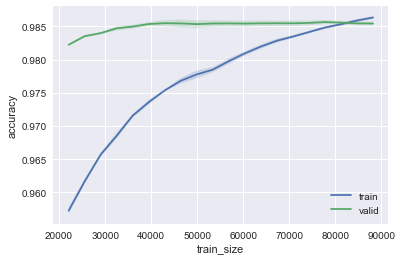

In [111]:
plot_learning_curve(val_train, val_test, n_train, xlabel='train_size', ylabel='accuracy')